In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy import create_engine, MetaData
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session


In [4]:
# create engine to hawaii.sqlite
engine = create_engine('sqlite:///Resources/hawaii.sqlite')


In [5]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set
from sqlalchemy import func
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the data set is: {most_recent_date}")

The most recent date in the data set is: 2017-08-23


<Figure size 1000x600 with 0 Axes>

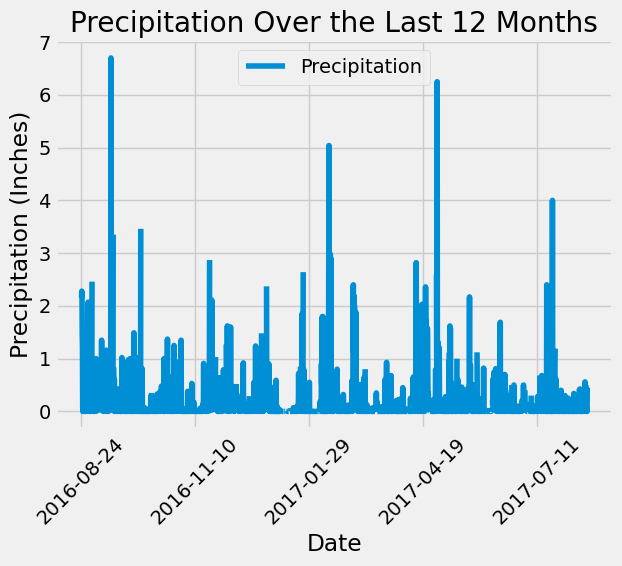

In [20]:
import datetime as dt
import pandas as pd

# Calculate the date one year from the last date in the dataset
last_date_query = session.query(func.max(Measurement.date)).scalar()
last_date = dt.datetime.strptime(last_date_query, '%Y-%m-%d')
one_year_ago = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
df.plot(x='Date', y='Precipitation', label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title('Precipitation Over the Last 12 Months')
plt.xticks(rotation=45)
plt.legend()
#plt.tight_layout()
plt.show()


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()

summary_statistics


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f"The total number of stations in the dataset is: {total_stations}")

The total number of stations in the dataset is: 9


In [15]:
# Design a query to find the most active stations
# List the stations and their counts in descending order
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
for station, count in most_active_stations:
    print(f"Station ID: {station}, Observation Count: {count}")

Station ID: USC00519281, Observation Count: 2772
Station ID: USC00519397, Observation Count: 2724
Station ID: USC00513117, Observation Count: 2709
Station ID: USC00519523, Observation Count: 2669
Station ID: USC00516128, Observation Count: 2612
Station ID: USC00514830, Observation Count: 2202
Station ID: USC00511918, Observation Count: 1979
Station ID: USC00517948, Observation Count: 1372
Station ID: USC00518838, Observation Count: 511


In [16]:
# Using the most active station id from the previous query
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station_id).all()
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"For the most active station (Station ID: {most_active_station_id}):")
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp} °F")

For the most active station (Station ID: USC00519281):
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66378066378067 °F


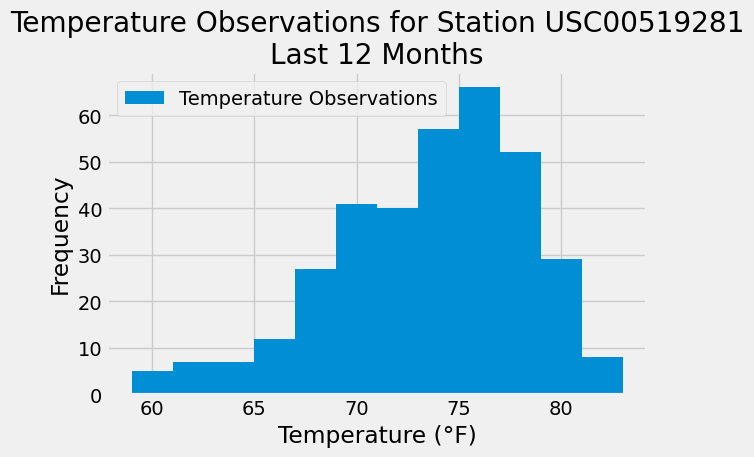

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
temperature_data = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == most_active_station_id).\
                    filter(Measurement.date >= one_year_ago).all()
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])
plt.hist(temperature_df['Temperature'], bins=12, label='Temperature Observations')
plt.title(f'Temperature Observations for Station {most_active_station_id}\nLast 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [18]:
# Close Session
session.close()